## Objective

Investigate the impact of data quality and cleaning strategies on the performance and interpretability of machine learning models applied to a real-world metabolomics dataset. The key objectives are:

### - **Train and Evaluate Classifiers**
Two classification models were trained on the original, dirty, and cleaned datasets:
- **Support Vector Machine (SVM)**
- **Multi-Layer Perceptron (MLP)**

Performance was evaluated using:
- **Accuracy**
- **Area Under the ROC Curve (AUC)**

### - **Analyze Feature Importance**
For each trained model, the **top 5 most important features** (metabolites) were extracted to assess how data quality and cleaning affect model interpretability.

### - **Compare Results**
A comprehensive comparison across 11 datasets (1 original, 4 dirty, and 6 cleaned) highlights:
- How different data degradation types and severities affect performance
- Which cleaning methods preserve model accuracy and AUC best
- How stable the top predictive features are across different scenarios


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator
import ast

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
)
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance
from typing import List, Dict

import os


import warnings


In [3]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


In [4]:
def run_full_analysis(dataset_paths: Dict[str, str], cat_features: List[str]):
    '''
    1. Split Dataset
    2. Build a Preprocessing Pipeline to Scale/Impute Values
    3. Evaluate 2 Machine Learning Models Using Scikit-Learn:
    - Build a paramater grid dict for each classifier.
    - Build GridSearchCV pipelines
    - Evaluate Models
    4. Extract 5 most important features for both of the resulting models
    5. Return a DataFrame with the results
    6. Stores trained models and data splits for later visualization

    '''
    results_all = []
    model_store = {} 

    for dataset_name, path in dataset_paths.items():
        print(f"\n--- Running analysis for {dataset_name} ---")
        df = pd.read_csv(path)
        if df.empty:
            print(f"Skipping {dataset_name} because it's empty!")
            continue

        X = df.drop(['Class'], axis=1)
        y = df['Class']

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.33, random_state=11, stratify=y
        )

        num_features = [c for c in X_train.columns if c not in cat_features]

        numeric_pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler()),
        ])

        categorical_pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')),
        ])

        preprocessor = ColumnTransformer([
            ('num', numeric_pipeline, num_features),
            ('cat', categorical_pipeline, cat_features),
        ])

        param_grid = {
            'Support Vector Classifier': {
                'C': [0.1, 1],
                'kernel': ['linear'],
                'gamma': ['scale']
            },
            'Neural Network Classifier': {
                'hidden_layer_sizes': [(50,)],
                'activation': ['relu'],
                'solver': ['adam'],
                'alpha': [0.0001],
                'learning_rate_init': [0.001]
            }
        }

        fixed_param_grid = {}
        for model_name, grid in param_grid.items():
            fixed_inner = {f"classifier__{param}": values for param, values in grid.items()}
            fixed_param_grid[model_name] = fixed_inner

        classifiers = [
            (SVC(probability=True, random_state=11), "Support Vector Classifier"),
            (MLPClassifier(max_iter=500, random_state=11), "Neural Network Classifier")
        ]

        classification_models = []
        for clf, name in classifiers:
            pipe = Pipeline([
                ('preprocessor', preprocessor),
                ('classifier', clf)
            ])
            gs = GridSearchCV(pipe, fixed_param_grid.get(name, {}), cv=5, n_jobs=-1)
            classification_models.append((gs, name))

        results_df = pd.DataFrame(columns=[
            'Dataset', 'Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'AUC', 'Top Features'
        ])

        for model, model_name in classification_models:
            model.fit(X_train, y_train)
            best_model = model.best_estimator_
            y_pred = best_model.predict(X_test)
            y_score = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, 'predict_proba') else best_model.decision_function(X_test)

            auc_val = roc_auc_score(y_test, y_score)
            precision = precision_score(y_test, y_pred, average='macro')
            recall = recall_score(y_test, y_pred, average='macro')
            f1 = f1_score(y_test, y_pred, average='macro')

            # Permutation importance
            r = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)
            pre = best_model.named_steps['preprocessor']
            num_feature_names = num_features
            cat_feature_names = pre.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(cat_features)
            all_feature_names = list(num_feature_names) + list(cat_feature_names)
            importances = r.importances_mean
            top_feats = [all_feature_names[i] for i in np.argsort(importances)[-5:][::-1]]

            results_df.loc[len(results_df)] = [
                dataset_name, model_name, round(model.best_score_, 3),
                round(precision, 3), round(recall, 3), round(f1, 3),
                round(auc_val, 3), top_feats
            ]

            #Store for visualizations
            model_store[(dataset_name, model_name)] = {
                "model": best_model,
                "X_test": X_test,
                "y_test": y_test, 
                "X_train": X_train,     
                "y_train": y_train  
            }

        results_all.append(results_df)

    final_results = pd.concat(results_all, ignore_index=True)
    return final_results, model_store


In [5]:
dataset_paths = {
    "original": "../data/MTBLS92_original.csv",
    "dirty_A_10": "../data/changed_values/MTBLS92_changed_10.csv",
    "dirty_A_50": "../data/changed_values/MTBLS92_changed_50.csv",
    "dirty_B_10": "../data/removed_values/MTBLS92_removed_10.csv",
    "dirty_B_50": "../data/removed_values/MTBLS92_removed_50.csv",
    "cleaned_10_simple": "../data/remove_cleaned/MTBLS92_cleaned_10_simple.csv",
    "cleaned_10_knn": "../data/remove_cleaned/MTBLS92_cleaned_10_knn.csv",
    "cleaned_10_dropna": "../data/remove_cleaned/MTBLS92_cleaned_10_dropna.csv",
    "cleaned_50_simple": "../data/remove_cleaned/MTBLS92_cleaned_50_simple.csv",
    "cleaned_50_knn": "../data/remove_cleaned/MTBLS92_cleaned_50_knn.csv",
    "cleaned_50_dropna": "../data/remove_cleaned/MTBLS92_cleaned_50_dropna.csv"
}

cat_features = ['Menopause', 'ER', 'Grade', 'Her2', 'N-stage', 'T-stage']

results_df, model_store = run_full_analysis(dataset_paths, cat_features)




--- Running analysis for original ---

--- Running analysis for dirty_A_10 ---

--- Running analysis for dirty_A_50 ---

--- Running analysis for dirty_B_10 ---

--- Running analysis for dirty_B_50 ---

--- Running analysis for cleaned_10_simple ---

--- Running analysis for cleaned_10_knn ---

--- Running analysis for cleaned_10_dropna ---
Skipping cleaned_10_dropna because it's empty!

--- Running analysis for cleaned_50_simple ---

--- Running analysis for cleaned_50_knn ---

--- Running analysis for cleaned_50_dropna ---
Skipping cleaned_50_dropna because it's empty!


In [6]:
results_df

,Dataset,Model,Accuracy,Precision,Recall,F1,AUC,Top Features
0,original,Support Vector Classifier,0.734,0.723,0.724,0.723,0.789,"[M59, M33, M110, M100, M66]"
1,original,Neural Network Classifier,0.704,0.735,0.737,0.736,0.800,"[M47, M48, M27, M52, M36]"
2,dirty_A_10,Support Vector Classifier,0.562,0.664,0.650,0.651,0.692,"[M90, M27, M63, M80, M66]"
3,dirty_A_10,Neural Network Classifier,0.639,0.711,0.704,0.706,0.764,"[M47, M23, M68, M65, M85]"
4,dirty_A_50,Support Vector Classifier,0.604,0.578,0.579,0.578,0.652,"[M10, M121, M66, M71, M35]"
5,dirty_A_50,Neural Network Classifier,0.657,0.624,0.621,0.622,0.617,"[M23, M27, M59, M132, M126]"
6,dirty_B_10,Support Vector Classifier,0.775,0.612,0.611,0.611,0.639,"[M90, M59, M62, M86, M76]"
7,dirty_B_10,Neural Network Classifier,0.674,0.710,0.707,0.708,0.766,"[M90, M91, M65, M64, M27]"
8,dirty_B_50,Support Vector Classifier,0.627,0.737,0.740,0.737,0.735,"[M62, M23, M33, M83, M101]"
9,dirty_B_50,Neural Network Classifier,0.657,0.663,0.665,0.664,0.706,"[M132, M53, M27, M54, M83]"


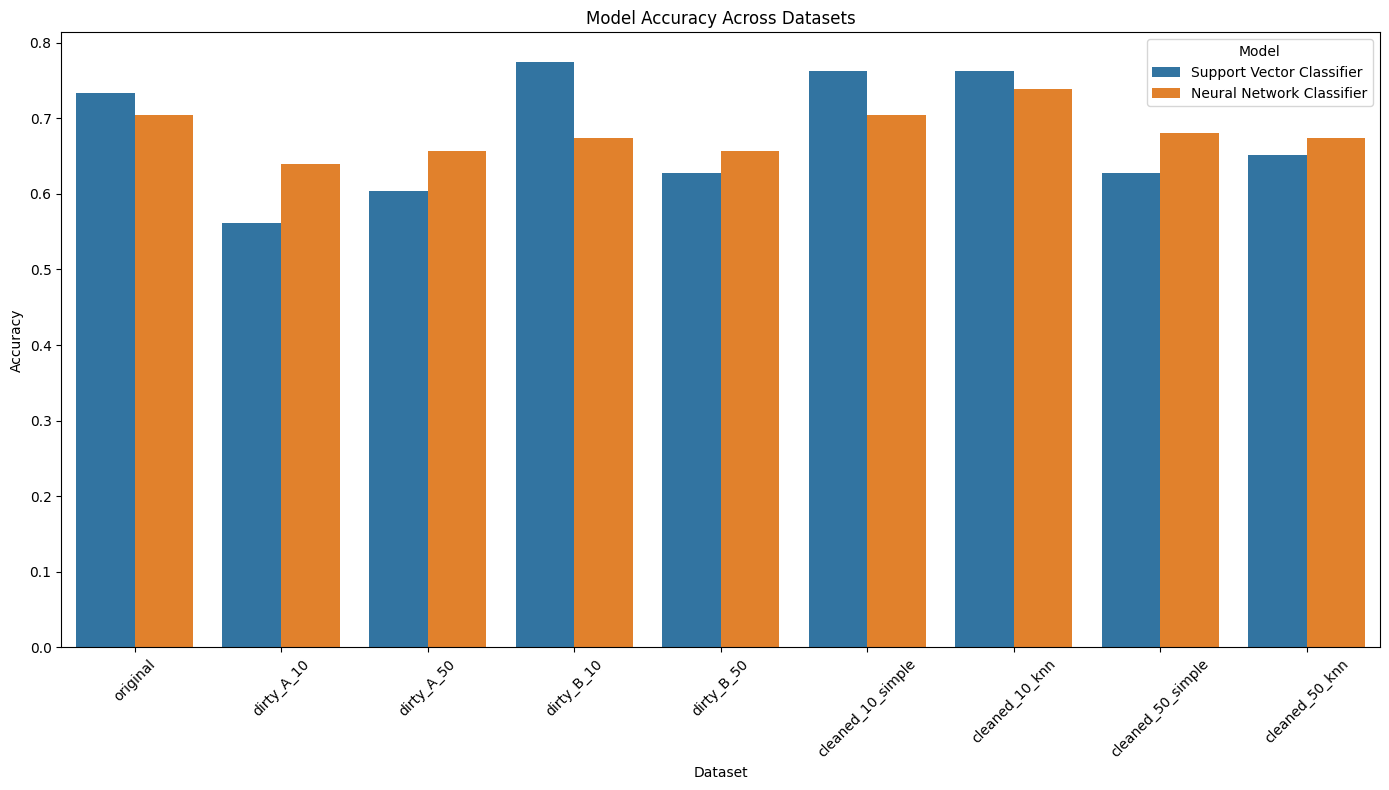

In [7]:
plt.figure(figsize=(14, 8))
sns.barplot(data=results_df, x="Dataset", y="Accuracy", hue="Model")
plt.xticks(rotation=45)
plt.title("Model Accuracy Across Datasets")
plt.tight_layout()
plt.show()



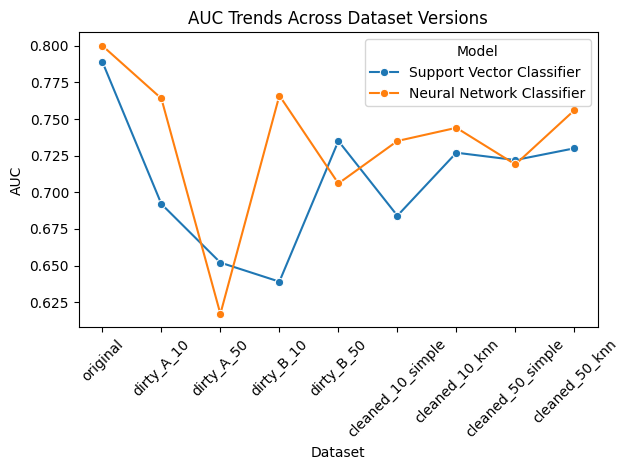

In [8]:
order = list(dataset_paths.keys()) 
sns.lineplot(data=results_df, x="Dataset", y="AUC", hue="Model", marker="o", sort=False)
plt.xticks(rotation=45)
plt.title("AUC Trends Across Dataset Versions")
plt.tight_layout()
plt.show()


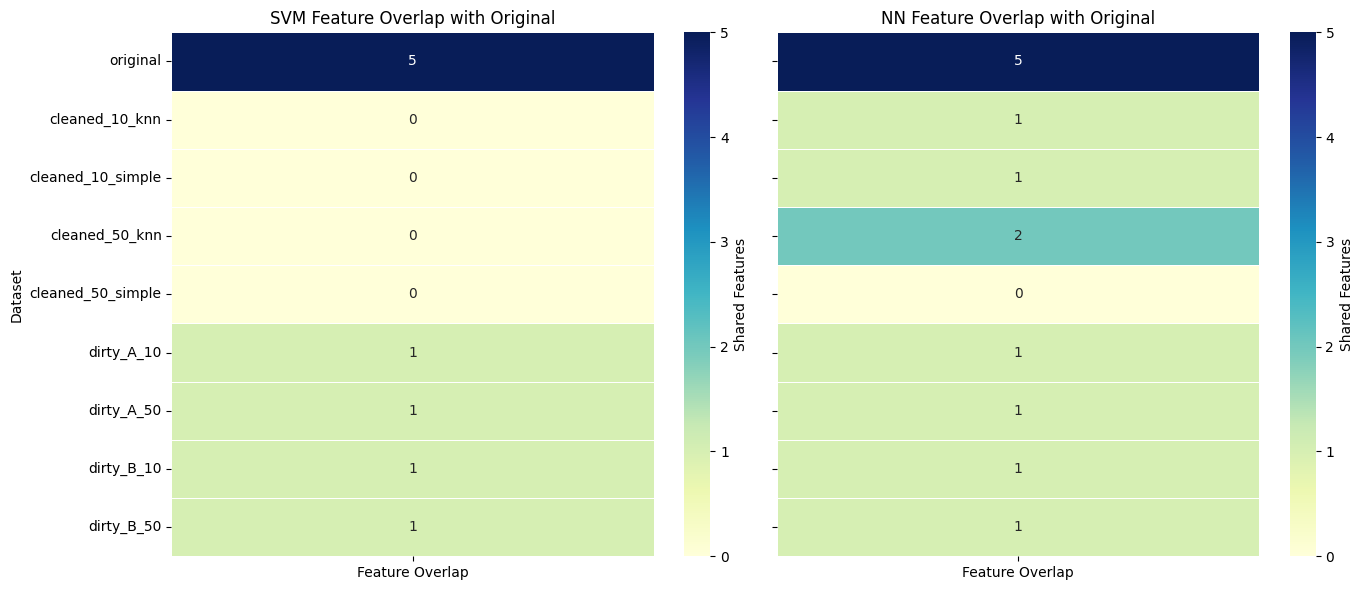

In [9]:

# Parse features safely
results_df["Parsed Features"] = results_df["Top Features"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

# original feature sets
original_features = {
    model: set(results_df.query("Dataset == 'original' and Model == @model")["Parsed Features"].iloc[0])
    for model in ["Support Vector Classifier", "Neural Network Classifier"]
}

# Compute overlap with corresponding original
results_df["Feature Overlap"] = results_df.apply(
    lambda row: len(set(row["Parsed Features"]) & original_features[row["Model"]]), axis=1
)

# Prepare label
results_df["Label"] = results_df["Dataset"]

# Pivot and reorder with 'original' first
def reorder_df(df, model_type):
    df_filtered = df[df["Model"] == model_type].set_index("Label")[["Feature Overlap"]]
    # Move 'original' to the top
    labels = ['original'] + sorted([l for l in df_filtered.index if l != 'original'])
    return df_filtered.loc[labels]

svm_df = reorder_df(results_df, "Support Vector Classifier")
nn_df = reorder_df(results_df, "Neural Network Classifier")

# Plot side-by-side heatmaps
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

sns.heatmap(svm_df, annot=True, cmap="YlGnBu", ax=axes[0],
            linewidths=0.5, cbar_kws={'label': 'Shared Features'})
axes[0].set_title("SVM Feature Overlap with Original")
axes[0].set_ylabel("Dataset")

sns.heatmap(nn_df, annot=True, cmap="YlGnBu", ax=axes[1],
            linewidths=0.5, cbar_kws={'label': 'Shared Features'})
axes[1].set_title("NN Feature Overlap with Original")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()


Moving on towards making a confusion matrix.

In [10]:
def plot_all_confusion_matrices(model_store: Dict, class_names: List[str]):
    import math
    from sklearn.metrics import confusion_matrix

    n_models = len(model_store)
    n_cols = 3
    n_rows = math.ceil(n_models / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))
    axes = axes.flatten()

    for i, ((dataset_name, model_name), data) in enumerate(model_store.items()):
        model = data['model']
        X_test = data['X_test']
        y_test = data['y_test']
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)

        sns.heatmap(
            cm, annot=True, fmt="d",
            xticklabels=class_names,
            yticklabels=class_names,
            cmap='crest',
            ax=axes[i]
        )
        axes[i].set_title(f"{dataset_name}\n{model_name}")
        axes[i].set_xlabel("Predicted")
        axes[i].set_ylabel("Actual")

    for j in range(len(model_store), len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle("Confusion Matrices Across All Datasets and Models", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


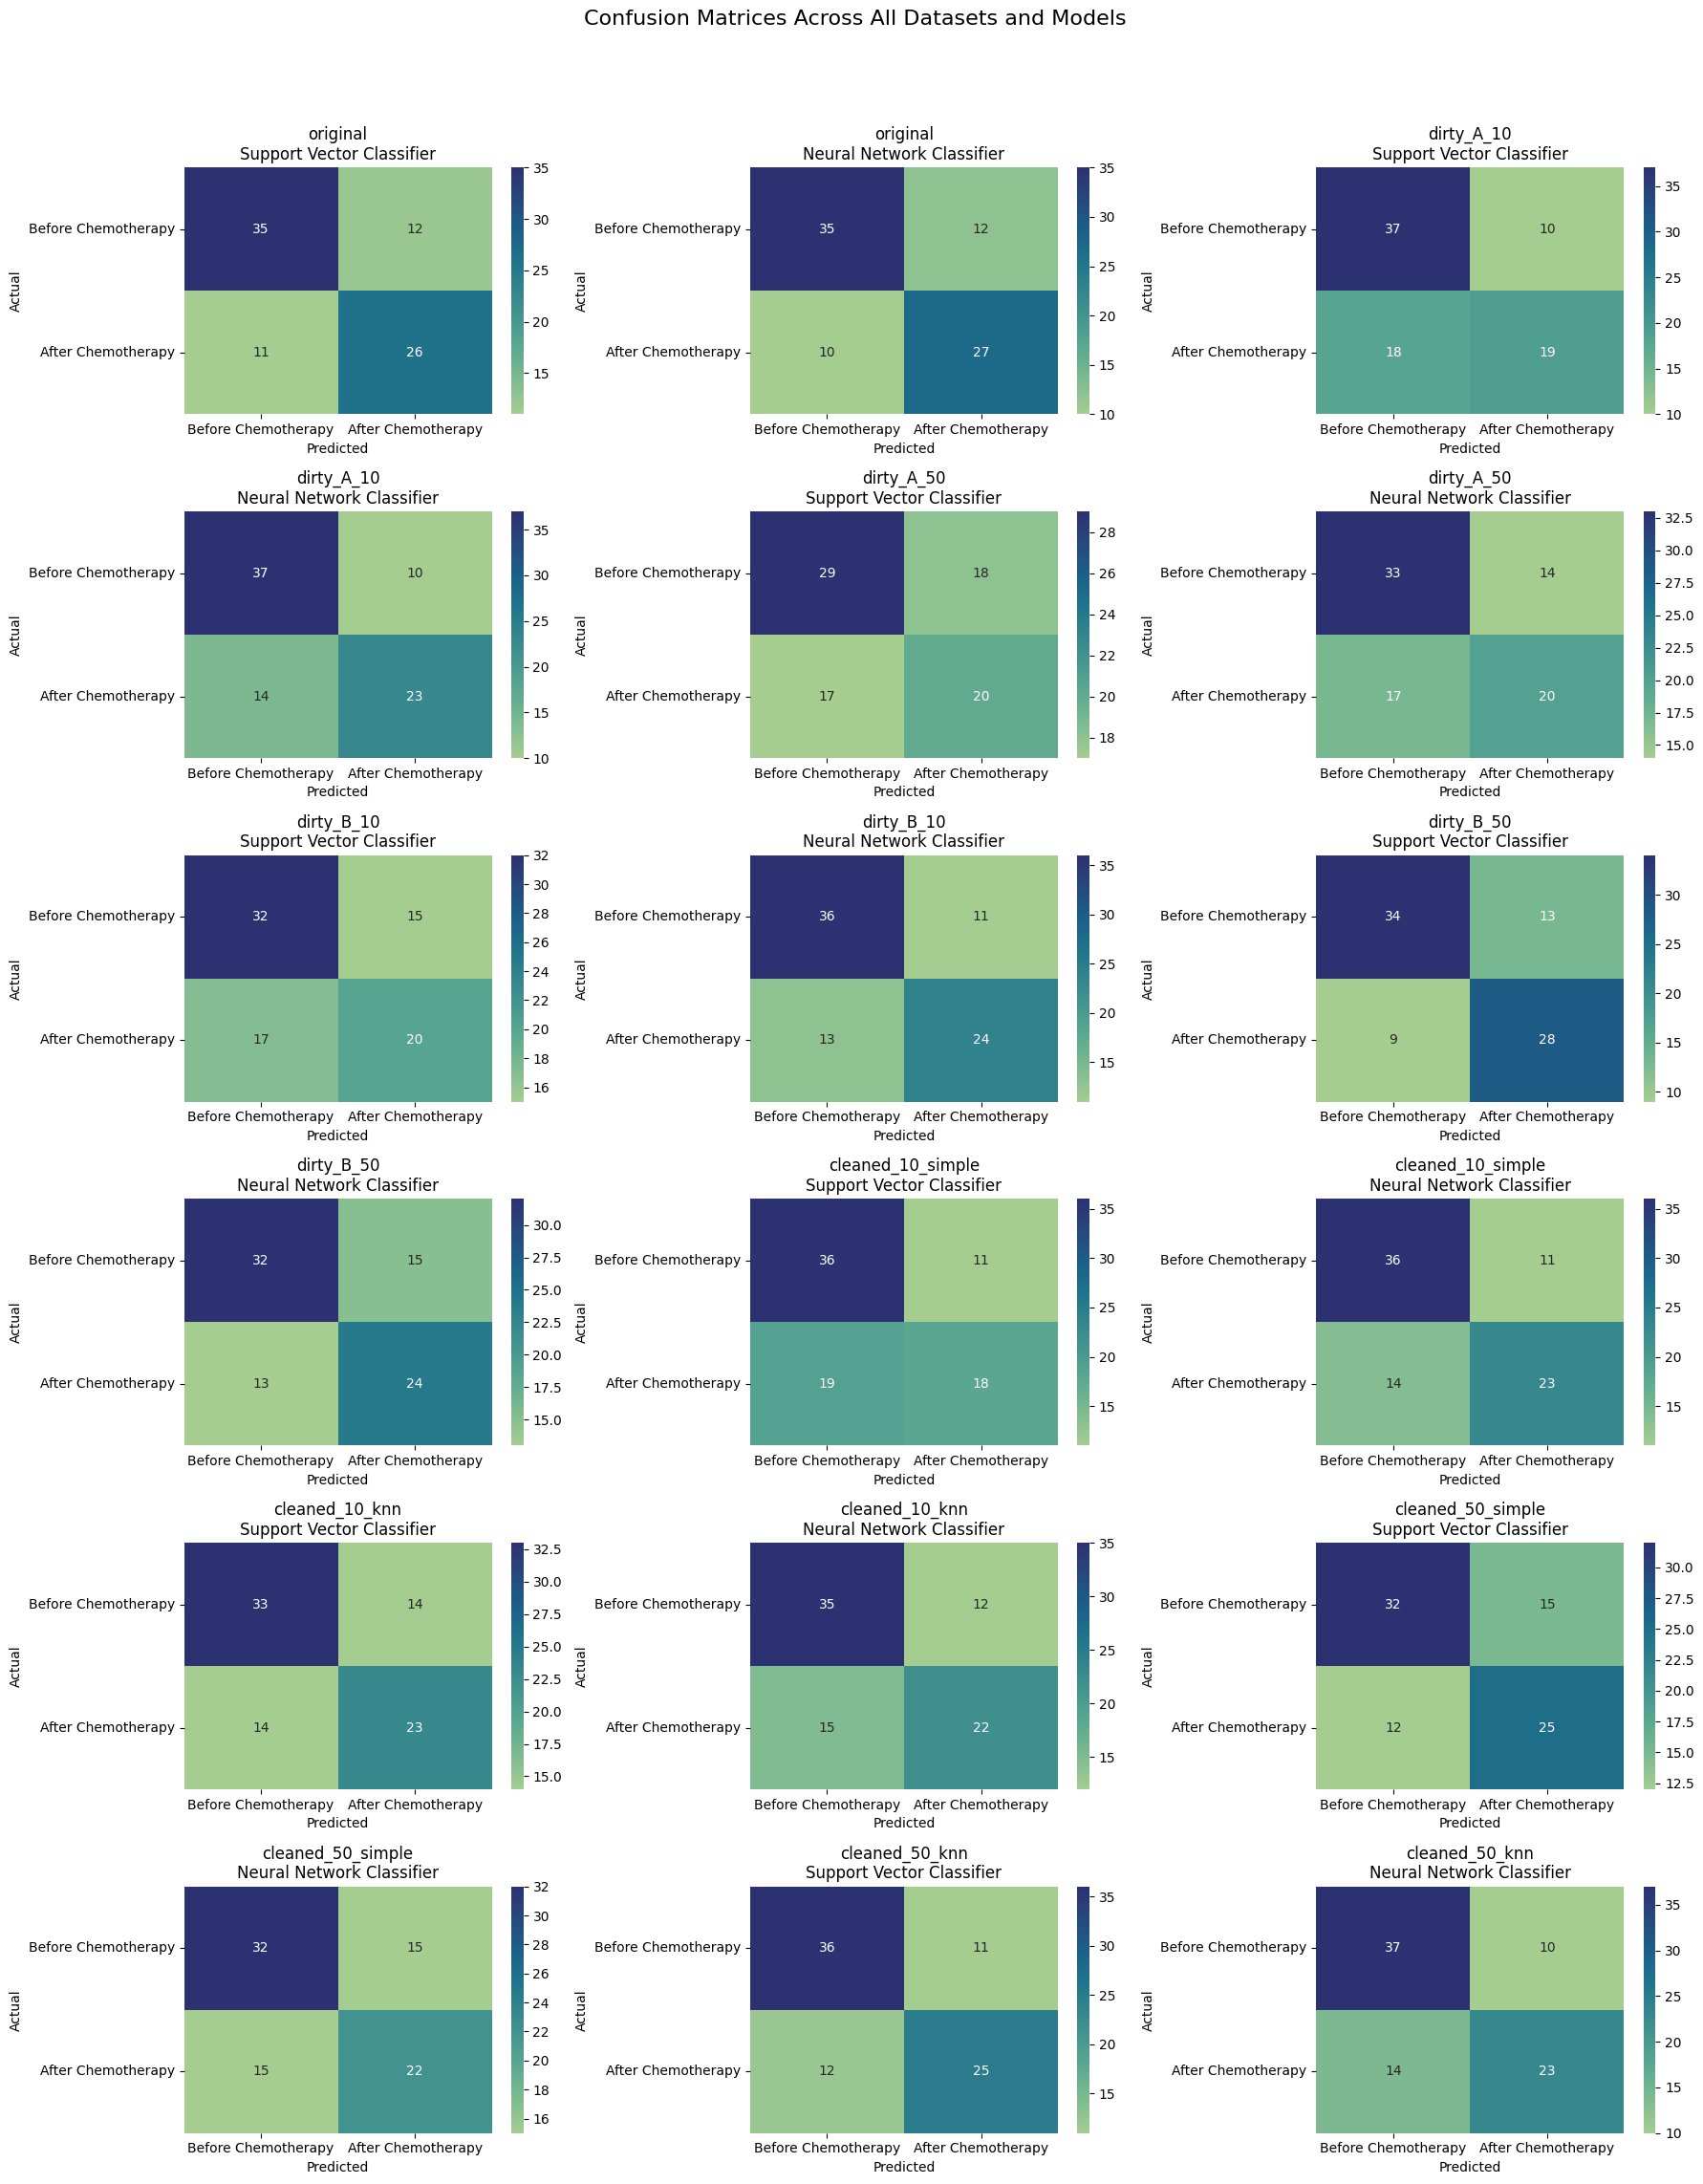

In [11]:
# Plot confusion matrices
plot_all_confusion_matrices(model_store, class_names=["Before Chemotherapy", "After Chemotherapy"])

Let's take a look at ROC/AUC as well. 

In [12]:
def plot_all_roc_curves(model_store: Dict, class_names: List[str]):
    import math

    n_models = len(model_store)
    n_cols = 4
    n_rows = math.ceil(n_models / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows), dpi=100)
    axes = axes.flatten()

    panel_labels = [chr(ord('A') + i) for i in range(n_models)]

    for i, ((dataset_name, model_name), data) in enumerate(model_store.items()):
        ax = axes[i]
        pipe = data['model']
        X_test = data['X_test']
        y_test = data['y_test']
        X_train = data.get('X_train')  
        y_train = data.get('y_train') 

        pos = pipe.classes_[1]

        try:
            y_te_score = pipe.predict_proba(X_test)[:, 1]
            y_tr_score = pipe.predict_proba(X_train)[:, 1] if X_train is not None else None
        except AttributeError:
            y_te_score = pipe.decision_function(X_test)
            y_tr_score = pipe.decision_function(X_train) if X_train is not None else None

        fpr_te, tpr_te, _ = roc_curve(y_test, y_te_score, pos_label=pos)
        auc_te = auc(fpr_te, tpr_te)

        if y_tr_score is not None:
            fpr_tr, tpr_tr, _ = roc_curve(y_train, y_tr_score, pos_label=pos)
            auc_tr = auc(fpr_tr, tpr_tr)
            ax.plot(fpr_tr, tpr_tr, color='#439140', lw=2.5, label=f"Train AUC {auc_tr:.2f}", zorder=3)

        ax.plot(fpr_te, tpr_te, color='#fbbd48', lw=2.5, label=f"Test AUC {auc_te:.2f}", zorder=3)
        ax.plot([0, 1], [0, 1], '--', lw=1.5, color='gray', zorder=1)

        # Styling
        ax.set_xlim(-0.05, 1.05)
        ax.set_ylim(-0.05, 1.05)
        ax.set_facecolor('white')
        ax.set_title(f"{panel_labels[i]}. {dataset_name} - {model_name}", loc='left', fontweight='bold', fontsize=12, pad=12)
        ax.set_xlabel("1 - Specificity", fontsize=11, labelpad=8, fontstyle='italic')
        ax.set_ylabel("Sensitivity", fontsize=11, labelpad=8, fontstyle='italic')
        ax.tick_params(axis='both', which='major', labelsize=9, width=1.2, length=6, direction='out')
        ax.xaxis.set_minor_locator(AutoMinorLocator(4))
        ax.yaxis.set_minor_locator(AutoMinorLocator(4))
        ax.tick_params(axis='both', which='minor', labelsize=0, width=1.0, length=3, direction='out')

        for spine in ['left', 'bottom']:
            ax.spines[spine].set_linewidth(1.2)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        ax.legend(frameon=False, fontsize=9, loc='lower right')

    for j in range(n_models, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(w_pad=4, h_pad=5)
    plt.subplots_adjust(top=0.94)
    plt.suptitle("ROC Curves Across All Datasets and Models", fontsize=16)
    plt.show()


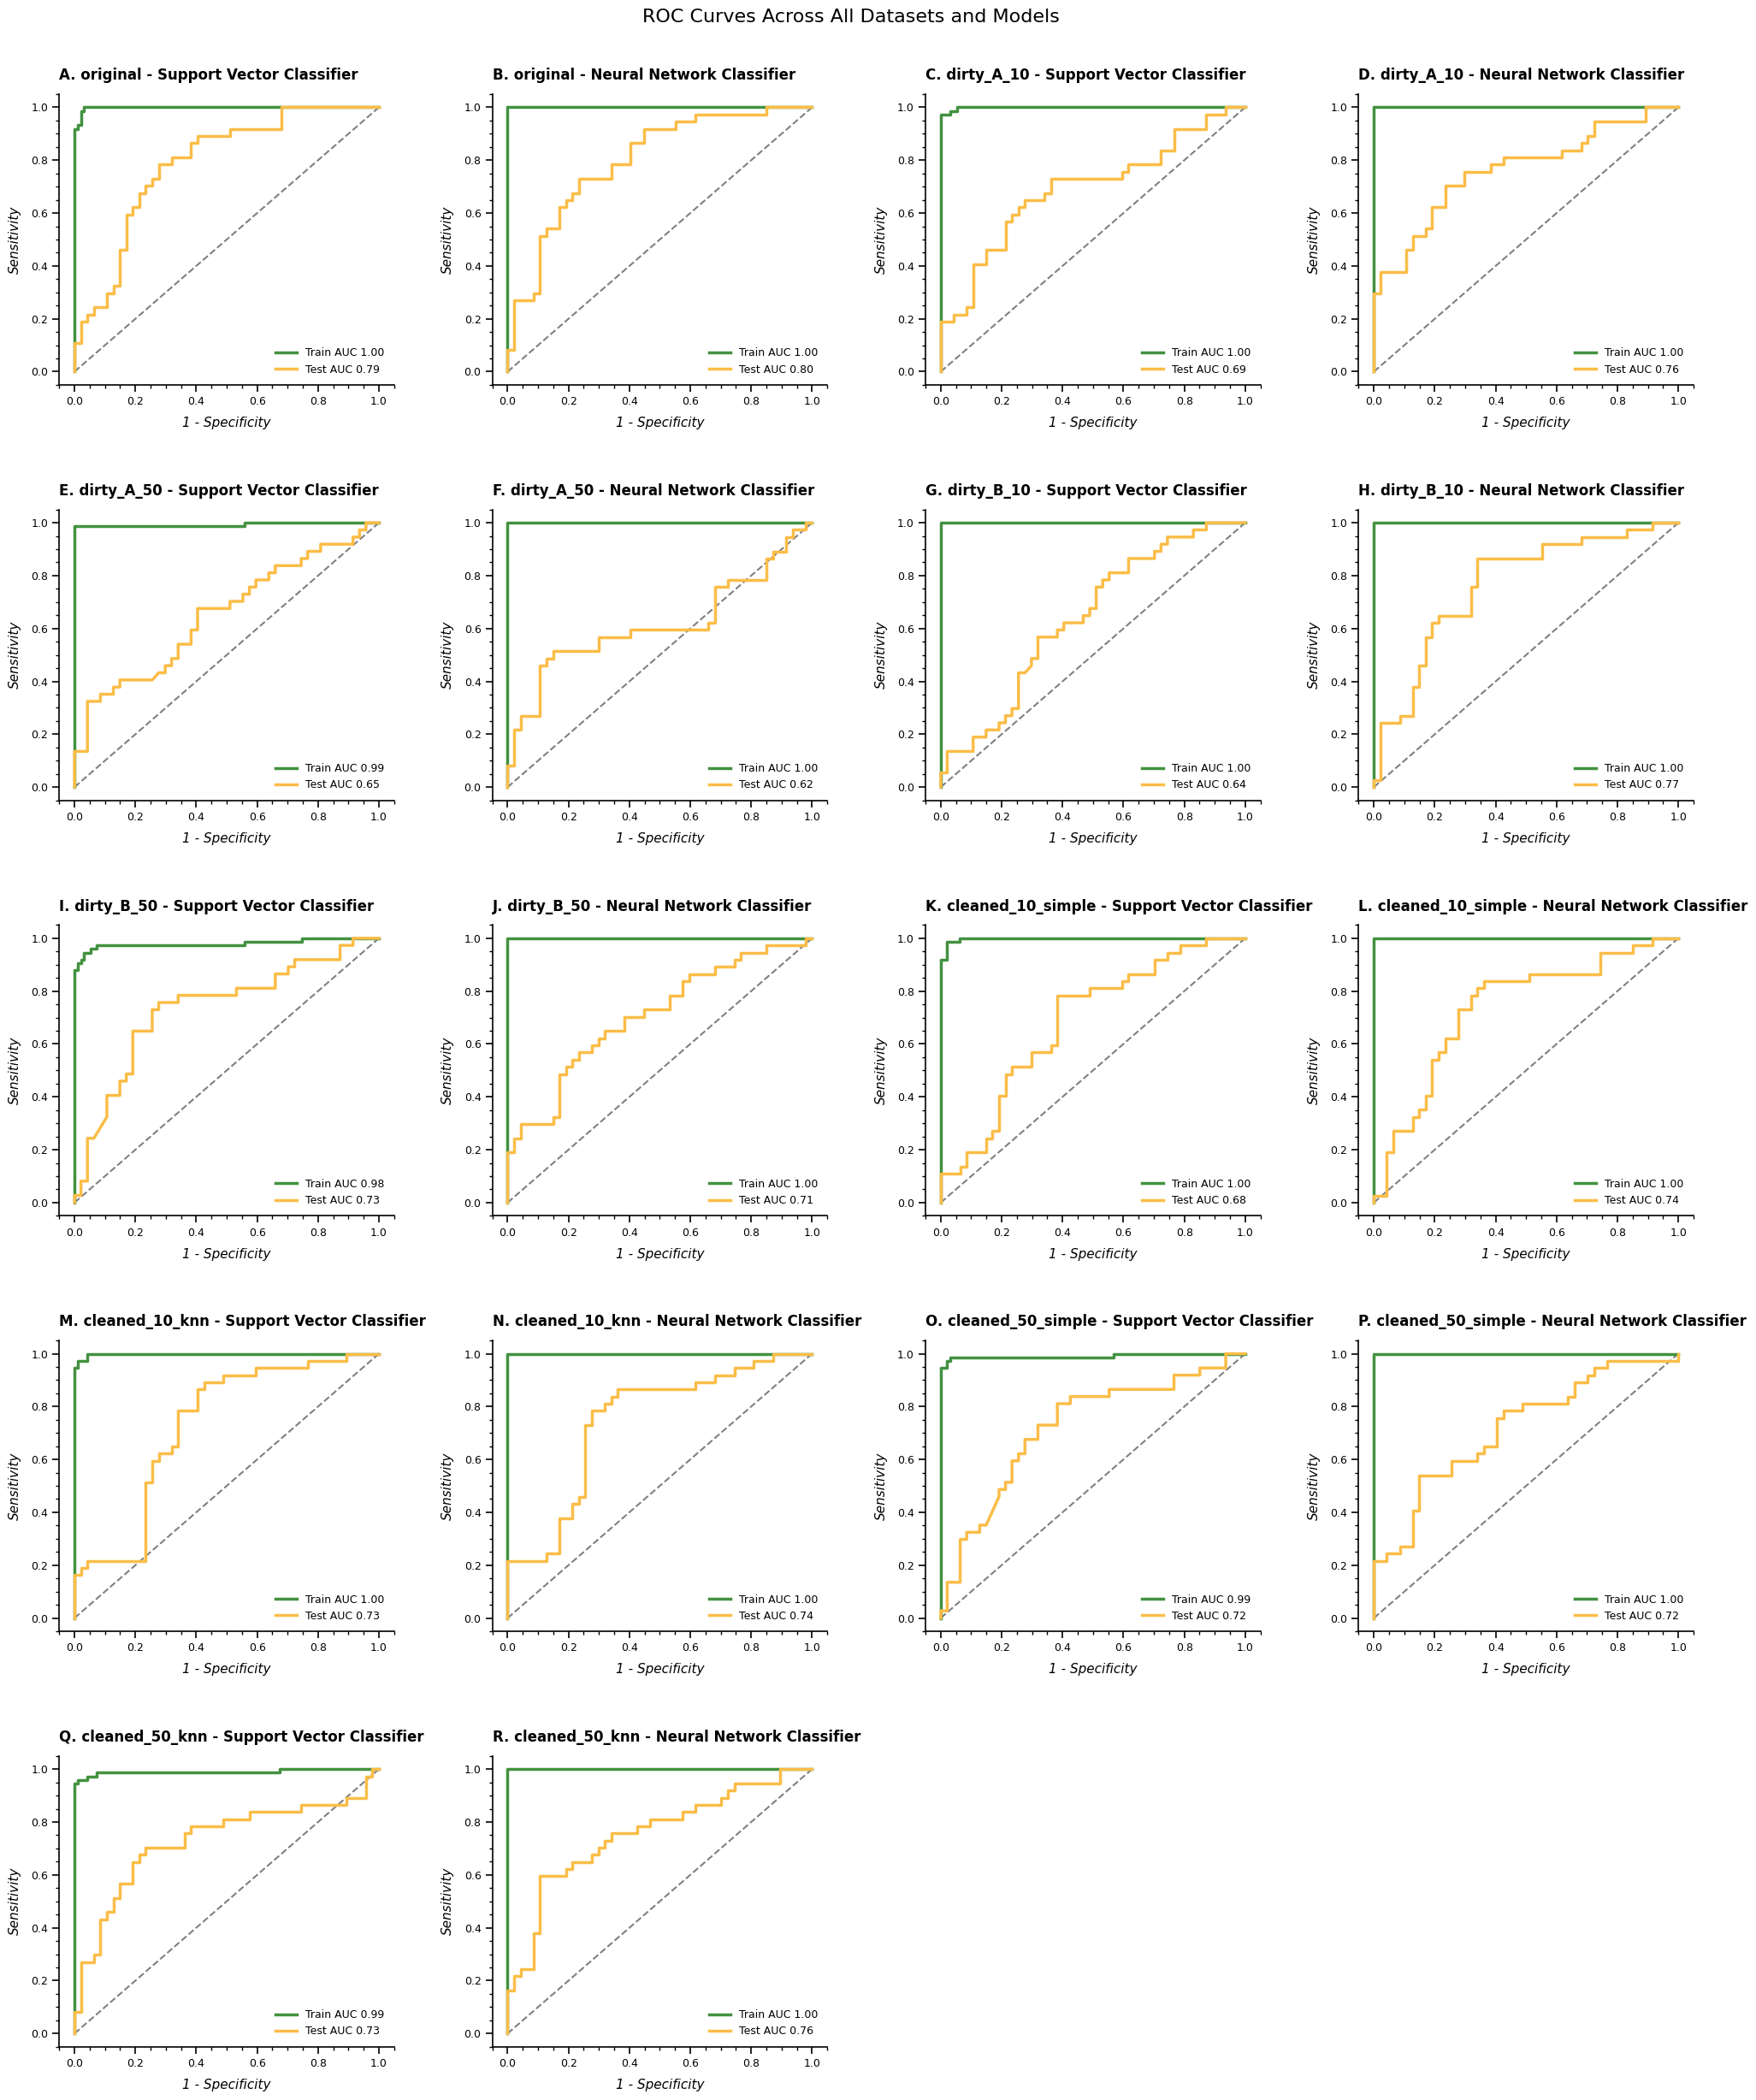

In [13]:
plot_all_roc_curves(model_store, class_names=["Before Chemotherapy", "After Chemotherapy"])

## Extracting Feature Importances

In [14]:
from sklearn.inspection import permutation_importance
import pandas as pd

def compute_top_feature_importances(model_store, cat_features, top_n=5):
    """
    Compute permutation importances for each model in model_store.

    Return DataFrame with top-N features per model-dataset pair.
    """
    all_rows = []

    for (dataset_name, model_name), model_data in model_store.items():
        print(f"Computing importance: {dataset_name} - {model_name}")
        model = model_data['model']
        X_test = model_data['X_test']
        y_test = model_data['y_test']

        # Get full feature names
        pre = model.named_steps['preprocessor']
        num_features = [c for c in X_test.columns if c not in cat_features]
        cat_feature_names = pre.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(cat_features)
        all_feature_names = list(num_features) + list(cat_feature_names)

        # Compute importance
        result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
        importances = result.importances_mean
        top_indices = importances.argsort()[::-1][:top_n]

        for rank, idx in enumerate(top_indices, 1):
            all_rows.append({
                "Dataset": dataset_name,
                "Model": model_name,
                "Feature": all_feature_names[idx],
                "Importance": importances[idx],
                "Rank": rank
            })

    return pd.DataFrame(all_rows)


In [15]:
importance_df = compute_top_feature_importances(model_store, cat_features, top_n=5)


Computing importance: original - Support Vector Classifier
Computing importance: original - Neural Network Classifier
Computing importance: dirty_A_10 - Support Vector Classifier
Computing importance: dirty_A_10 - Neural Network Classifier
Computing importance: dirty_A_50 - Support Vector Classifier
Computing importance: dirty_A_50 - Neural Network Classifier
Computing importance: dirty_B_10 - Support Vector Classifier
Computing importance: dirty_B_10 - Neural Network Classifier
Computing importance: dirty_B_50 - Support Vector Classifier
Computing importance: dirty_B_50 - Neural Network Classifier
Computing importance: cleaned_10_simple - Support Vector Classifier
Computing importance: cleaned_10_simple - Neural Network Classifier
Computing importance: cleaned_10_knn - Support Vector Classifier
Computing importance: cleaned_10_knn - Neural Network Classifier
Computing importance: cleaned_50_simple - Support Vector Classifier
Computing importance: cleaned_50_simple - Neural Network Cla

In [16]:
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
import os

def get_feature_names(model, X_test, cat_features):
    pre = model.named_steps['preprocessor']
    num_features = [c for c in X_test.columns if c not in cat_features]
    cat_feature_names = pre.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(cat_features)
    return list(num_features) + list(cat_feature_names)

def plot_feature_importances_for_all_datasets(model_store, cat_features, top_n=5, save=False, output_dir="../report/feature_plots"):
    os.makedirs(output_dir, exist_ok=True)

    datasets = sorted(set(k[0] for k in model_store.keys()))  # Get all unique dataset names

    for dataset in datasets:
        try:
            # Get models and data
            best_svc = model_store[(dataset, "Support Vector Classifier")]["model"]
            best_nn  = model_store[(dataset, "Neural Network Classifier")]["model"]
            X_test   = model_store[(dataset, "Support Vector Classifier")]["X_test"]
            y_test   = model_store[(dataset, "Support Vector Classifier")]["y_test"]

            # Get feature names
            all_feature_names = get_feature_names(best_svc, X_test, cat_features)

            # Compute importances
            svc_result = permutation_importance(best_svc, X_test, y_test, n_repeats=10, random_state=42)
            nn_result  = permutation_importance(best_nn,  X_test, y_test, n_repeats=10, random_state=42)

            svc_importances = svc_result.importances_mean
            nn_importances  = nn_result.importances_mean

            top_indices_svc = svc_importances.argsort()[::-1][:top_n]
            top_indices_nn  = nn_importances.argsort()[::-1][:top_n]

            # Plot
            fig, axes = plt.subplots(1, 2, figsize=(16, 6))
            fig.suptitle(f"Top {top_n} Feature Importances – {dataset}", fontsize=14)

            # SVC
            axes[0].barh(
                [all_feature_names[i] for i in top_indices_svc],
                svc_importances[top_indices_svc]
            )
            axes[0].set_title("Support Vector Classifier")
            axes[0].set_xlabel("Importance")
            axes[0].invert_yaxis()

            # NN
            axes[1].barh(
                [all_feature_names[i] for i in top_indices_nn],
                nn_importances[top_indices_nn]
            )
            axes[1].set_title("Neural Network")
            axes[1].set_xlabel("Importance")
            axes[1].invert_yaxis()

            plt.tight_layout()
            plt.subplots_adjust(top=0.88)

            
            plt.show()

        except KeyError as e:
            print(f"Skipping {dataset}: missing model or data ({e})")


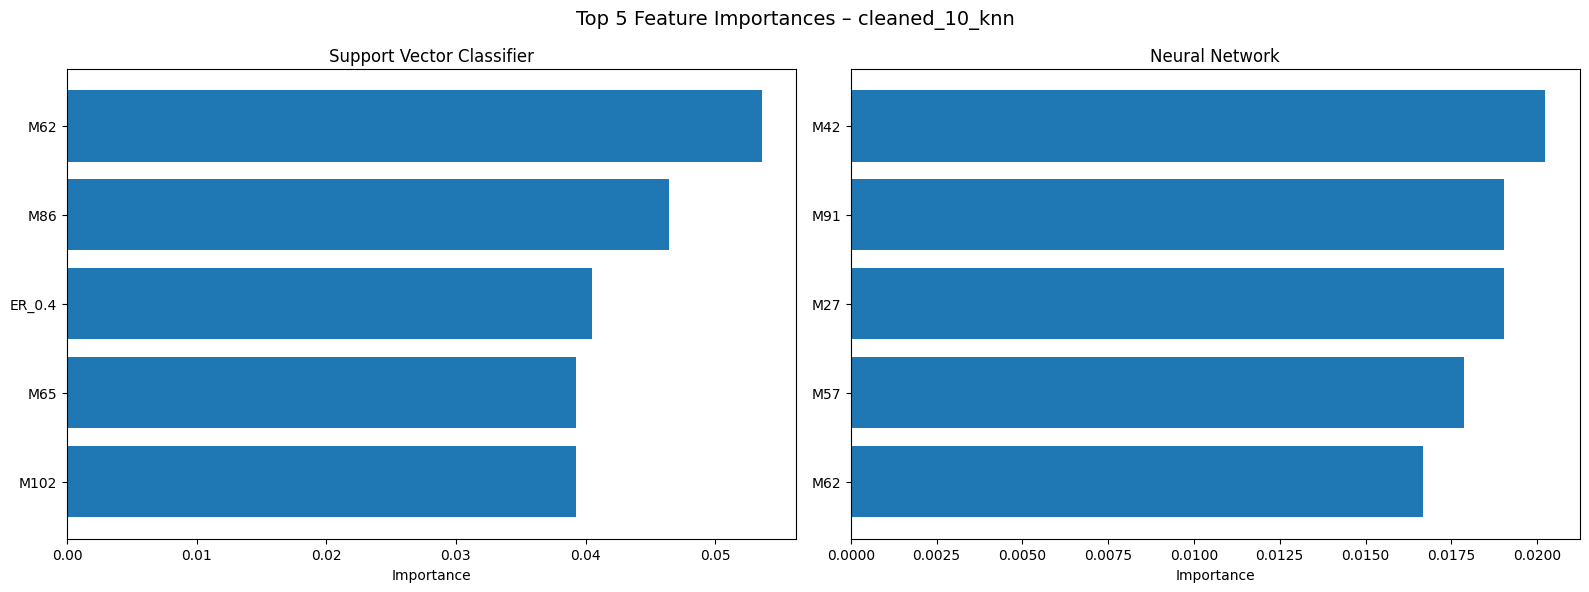

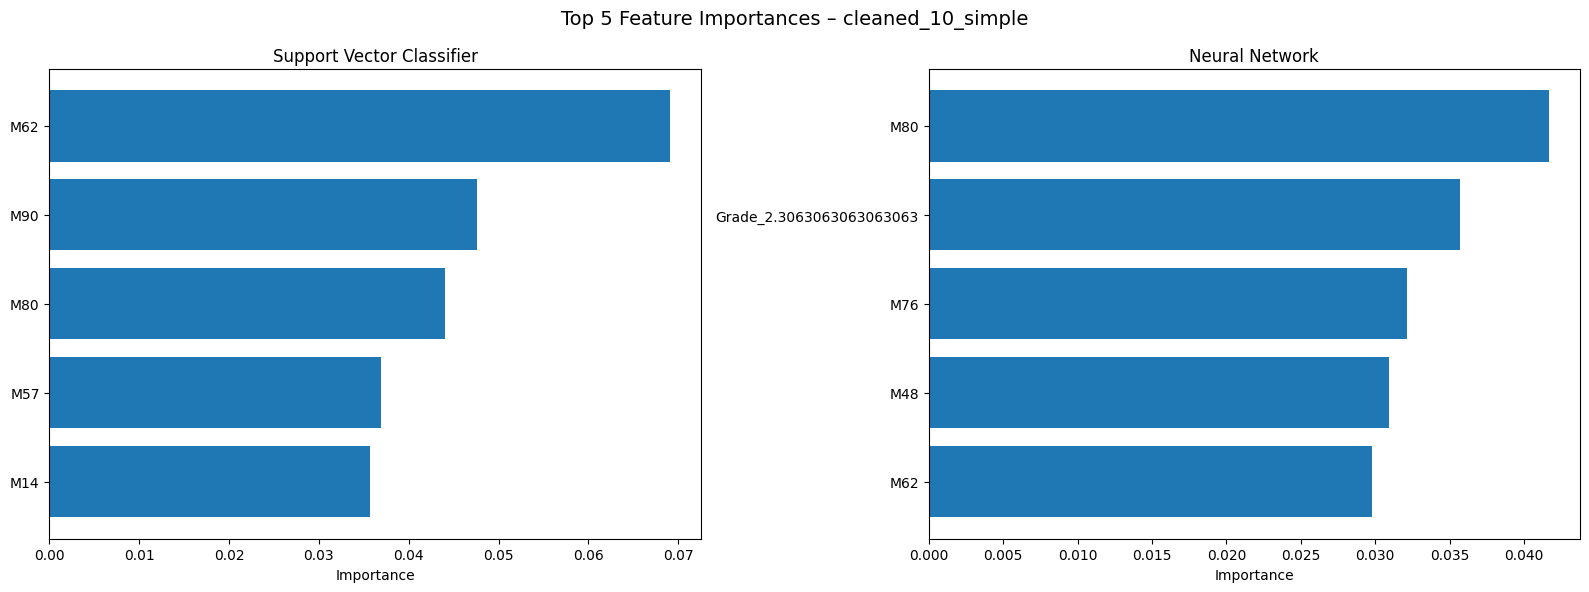

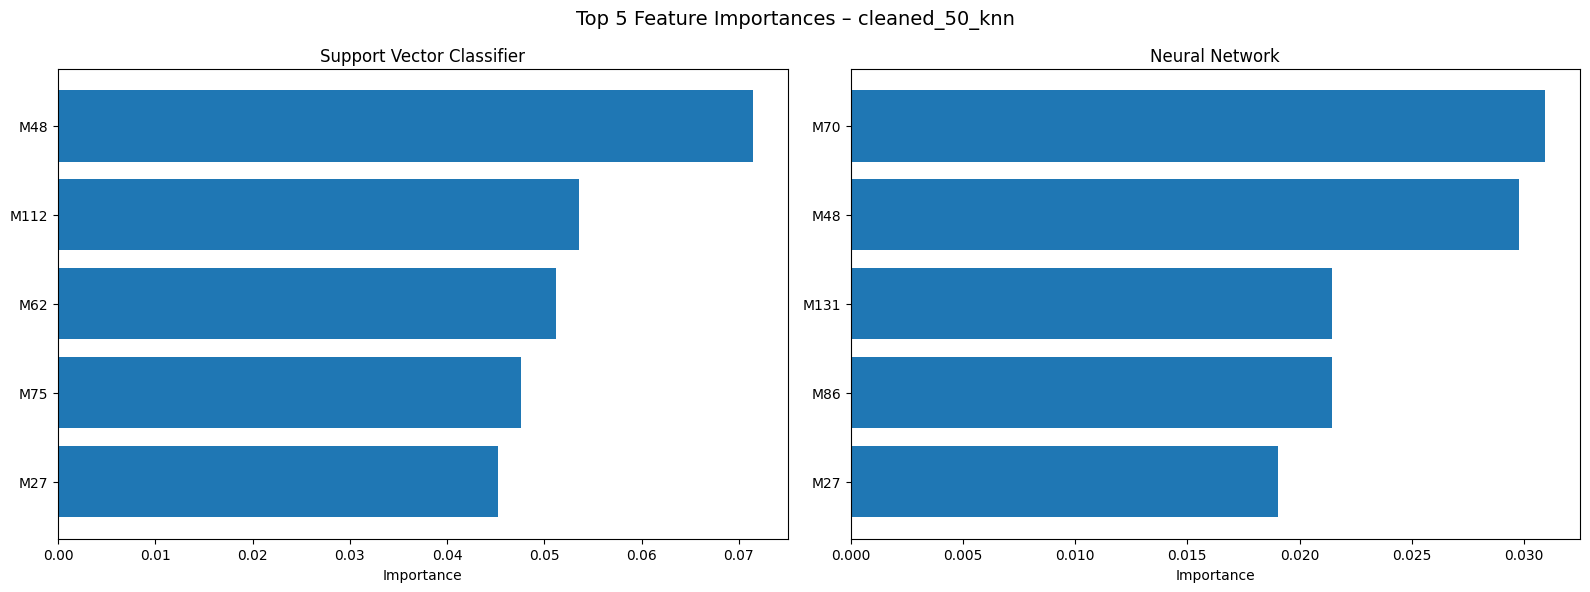

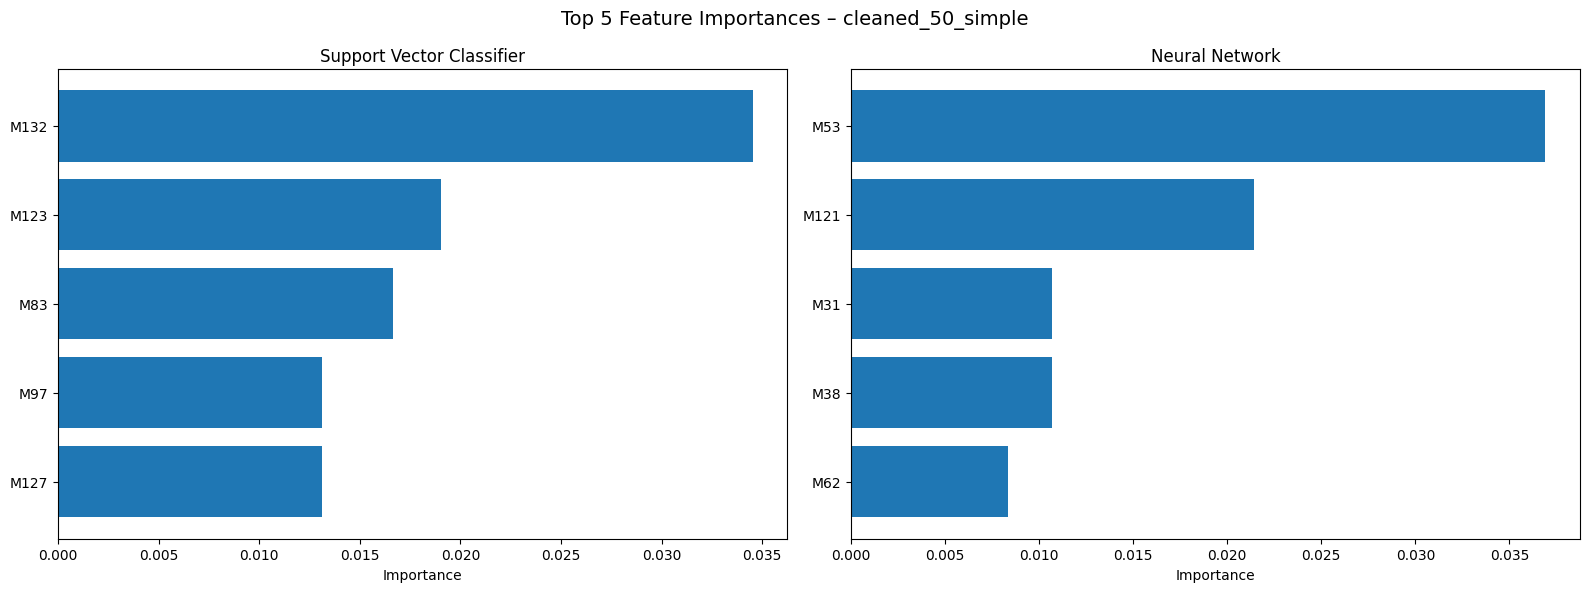

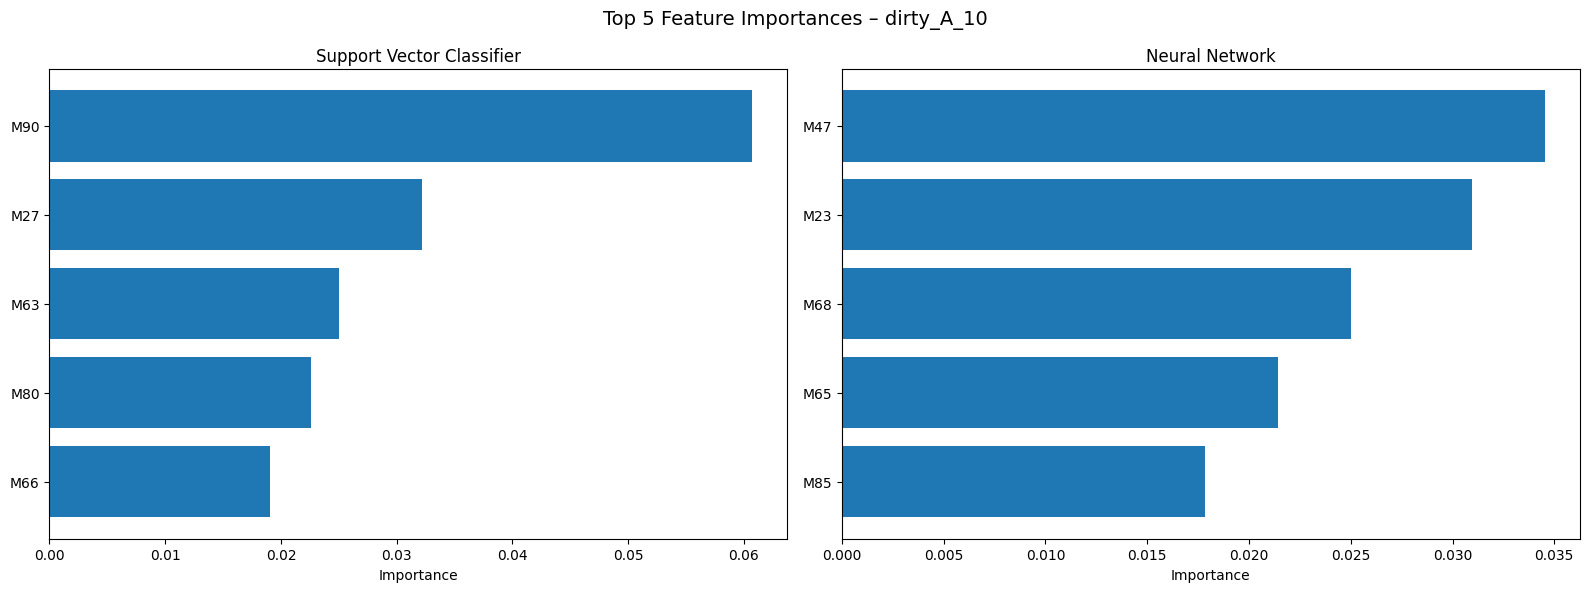

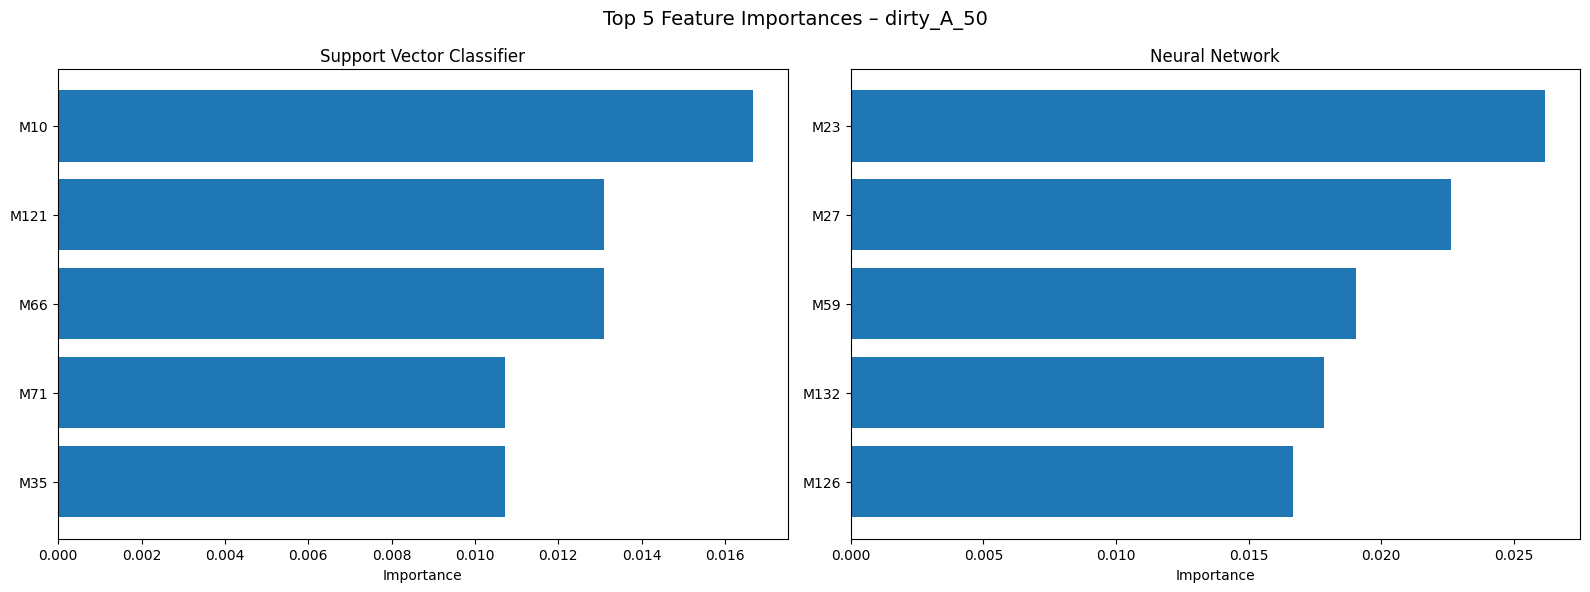

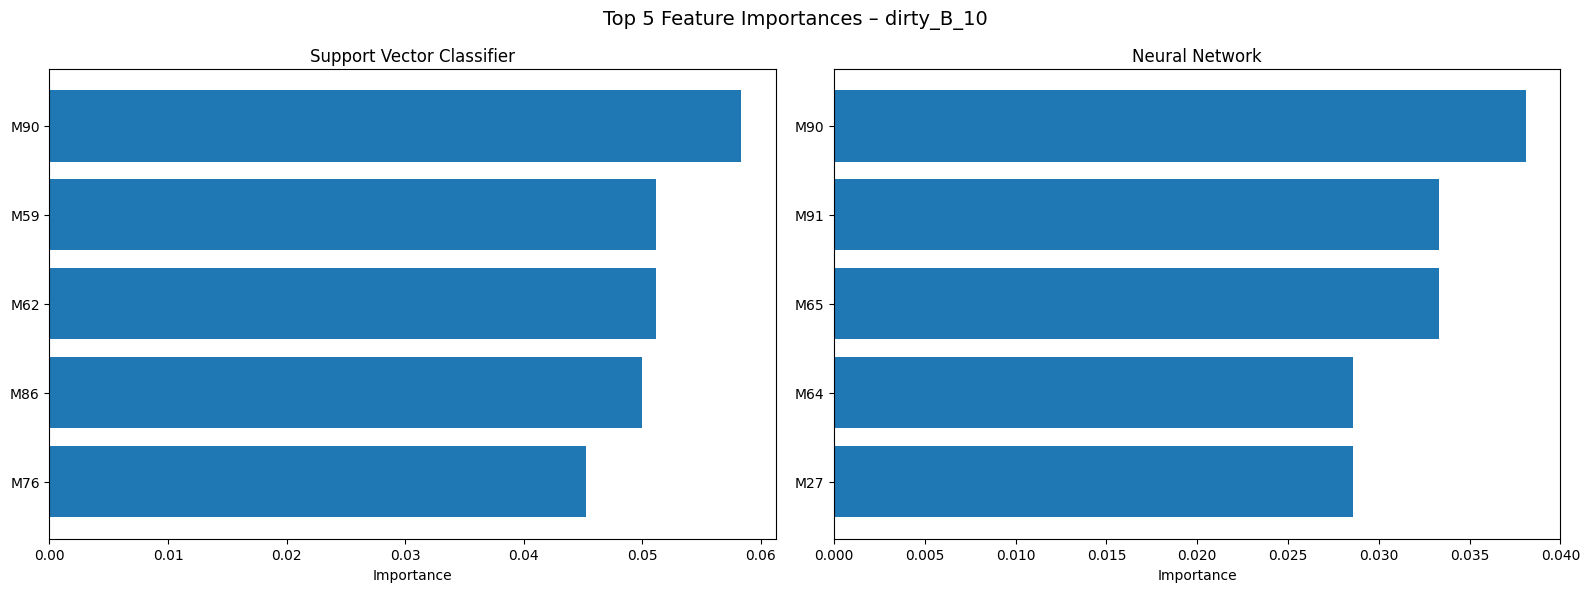

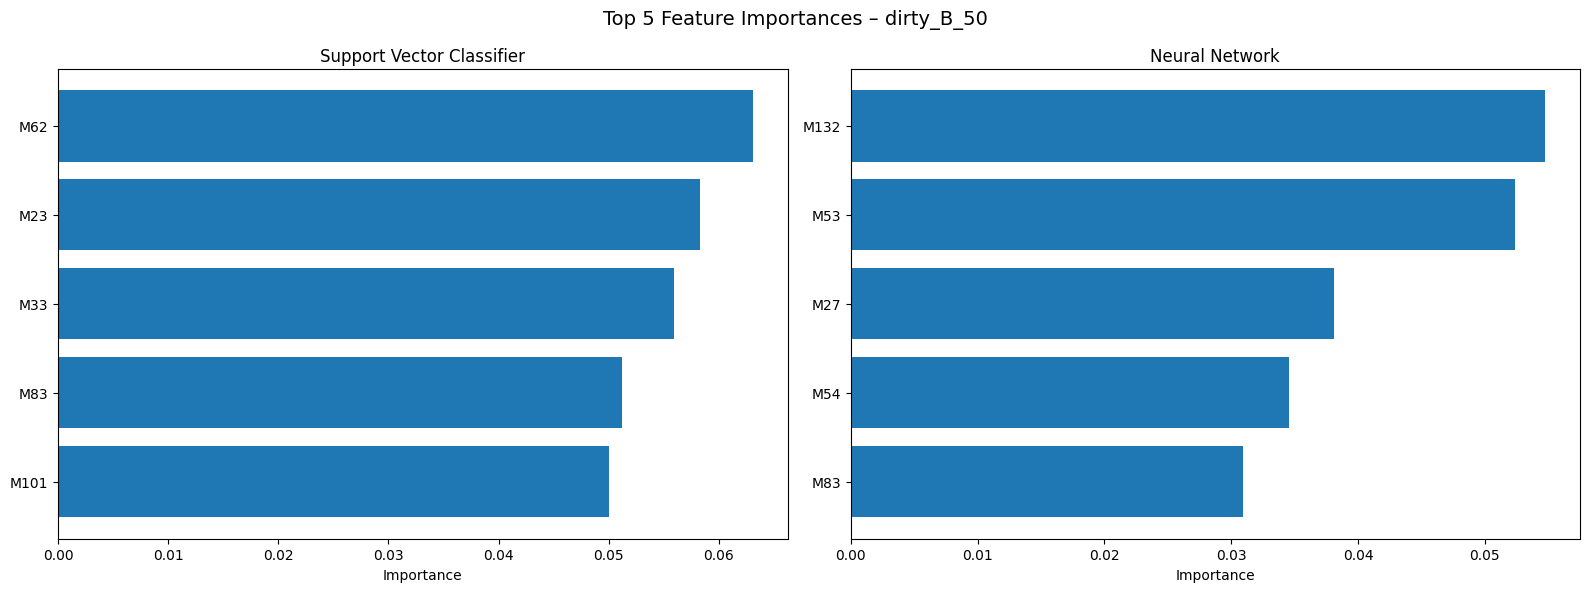

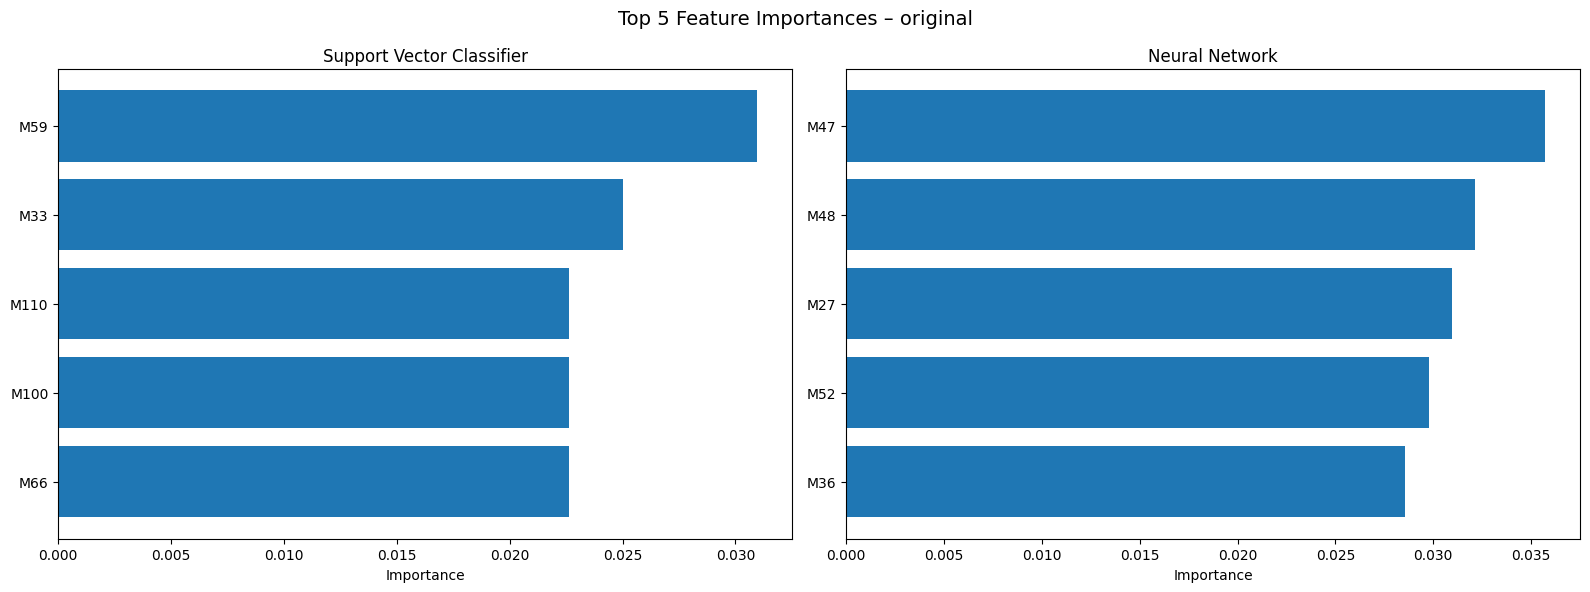

In [17]:
plot_feature_importances_for_all_datasets(
    model_store,
    cat_features=cat_features,
    top_n=5
)
